In [1]:
# 1. Module Import
import numpy as np  # 1. 선형대수와 관련된 함수를 쉽게 이용할 수 있는 모듈 
import matplotlib.pyplot as plt  # 2. 함수 실행 결과 산출물에 대한 수치를 사람이쉽게 이해할 수 있도록 시각화 할 수 있는 외부 모듈
import torch  # 3. 우리가 이용하는 딥러닝 프레임워크 중 하나인 파이토치의 기본 모듈
import torch.nn as nn  # 4. pyTorch.Module 중 딥러닝 , 즉 인공 신경망 모델을 설계할 떄 필요한 함수를 모아 놓은 모듈
import torch.nn.functional as F  # 5. torch.nn 은  모듈 중에서도 자주 이용되는 함수를 F 로 지정
from torchvision import transforms, datasets  # 6. 컴퓨터 비전 연구 분야에서 자주 이용하는 'torchvision' 모듈 내 ' transforms', 'datasets'함수를 임포트

In [2]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")



Torch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA version: 12.6
CUDA available: True
GPU name: NVIDIA GeForce RTX 3070


In [3]:
# 딥러닝 모델을 설계할 때 활용하는 장비 확인 
if torch.cuda.is_available():
    DEVICE =torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:',torch.__version__ , 'Device:', DEVICE)

Using PyTorch version: 2.8.0+cu126 Device: cuda


In [4]:
# 하이퍼 파라미터 지정
BATCH_SIZE = 32  # MLP 학습시 Mini-Batch 1회(Iteration)당 사용되는 학습 데이터 수
EPOCHS = 10  # 전체 데이터를 이용해 학습을 진행한 횟수, ex) 전체 데이터 1만개, Mini_Batch 1개당 BATCH_SIZE 1000개 = Mini_Batch 10Iteration = 1 EPOCH 


In [5]:
# MNIST 데이터 다운로드 및 DataLoader 구성 (Train/Test 세트 분리)

# 1. 학습용 데이터셋 다운로드
train_dataset = datasets.MNIST(
    root="./data/MNIST",               # 데이터를 저장할 디렉토리 경로
    train=True,                        # 학습용 데이터 지정
    download=True,                     # 데이터가 없으면 인터넷에서 자동 다운로드
    transform=transforms.ToTensor()    # 이미지를 Tensor로 변환 (0~1 범위로 정규화됨)
)

# 2. 테스트용 데이터셋 다운로드
test_dataset = datasets.MNIST(
    root="./data/MNIST",               # 동일한 저장 경로
    train=False,                       # 테스트용 데이터 지정
    transform=transforms.ToTensor()    # 이미지 Tensor 변환 및 정규화
)

# 3. 학습용 데이터 로더 설정
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,             # 학습 데이터셋 지정
    batch_size=BATCH_SIZE,             # 한 번에 불러올 데이터 수
    shuffle=True                       # 매 epoch마다 데이터를 섞어서 학습 (일반적으로 True로 설정)
)

# 4. 테스트용 데이터 로더 설정
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,              # 테스트 데이터셋 지정
    batch_size=BATCH_SIZE,             # 테스트 시에도 동일한 배치 크기 사용
    shuffle=False                      # 테스트 데이터는 순서를 유지 (일반적으로 False)
)


In [6]:
# 4. 데이터 확인하기(1)
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(),'type:',x_train.type())   # 32개의 이미지 데이터 = Mini-Batch 1개 구성  = 한 개의 이미지는 가로 28개, 세로 28개의 픽셀, 채널 1개인 흑백 이미지 데이터
    print('y_train:', y_train.size(),'type:',y_train.type())   # 32개의 이미지 데이터 각각의 대한 라벨링 데이터  
    break


x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


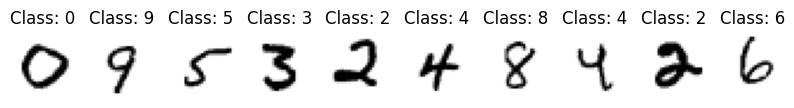

In [7]:
# 5. 데이터 확인하기(2) 
pltsize = 1 
plt.figure(figsize=(10 * pltsize,pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28), cmap ='grey_r')
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
# 6. 다층 퍼셉트론(MLP) 모델 정의
class Net(nn.Module):  # nn.module → nn.Module (클래스명은 대문자로 시작해야 함)
    def __init__(self):
        super(Net, self).__init__() 
        
        # 첫 번째 완전 연결층 (입력: 28x28 픽셀 → 출력: 512 노드)
        self.fc1 = nn.Linear(28*28, 512)  

        # 두 번째 완전 연결층 (입력: 512 노드 → 출력: 256 노드)
        self.fc2 = nn.Linear(512, 256)

        # 세 번째 완전 연결층 (입력: 256 노드 → 출력: 10 클래스)
        self.fc3 = nn.Linear(256, 10)

        # Layer의 50%의 노드에 대해서 가중값을 계산하지 않을것으로 정의
        self.dropout_prob=0.5
        
        # 1차원 배치 정규화 (적용되는 차원마다 함수이름이 다름)
        self.batch_norm1 = nn.BatchNorm1d(512)  # 첫 번째 완전 연결층 Output이 512크기의 벡터값이므로 512로 설정
        self.batch_norm2 = nn.BatchNorm1d(256)  # 두 번째 완전 연결층 Output이 256크기의 벡터값이므로 256로 설정
        
    def forward(self, x):
        # 이미지를 1차원 벡터로 변환 (배치 크기, 784)
        x = x.view(-1, 28*28)

        # 첫 번째 층 + BN + ReLU 활성화 함수
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) 
        
        # MLP 내의 비선형 함수의 OutPut에 DropOut 적용
        x = F.dropout(x,training=self.training,p=self.dropout_prob)
        
        # 두 번째 층 + BN + ReLU 활성화 함수
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        # MLP 내의 비선형 함수의 OutPut에 DropOut 적용
        x = F.dropout(x,training=self.training,p=self.dropout_prob)

        # 세 번째 층 + log_softmax 활성화 함수 (출력: 확률 로그값)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x


In [9]:
# 7. Optimizer, Objective Function 설정 
import torch.nn.init as init 

# 가중치 초기화 함수 정의
def weight_init(m):
    # m이 nn.Linear 즉 선형결합 층(Linear layer)인 경우에만 초기화 수행 
    if isinstance(m, nn.Linear):
        # kaming 균등분포 초기화 적용 (He 초기화)
        init.kaiming_uniform(m.weight.data)

# 모델을 DEVICE(GPU or CPU)로 이동 
model = Net().to(DEVICE)

# 정의한 초기화 함수를 모델의 모든 서브모듈(층:layer)에 적용
model.apply(weight_init)

# 최적화 알고리즘 SGD 채택 및 옵션 설정 (학습률 0.01, 모멘텀 0.5)
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01, momentum=0.5)

# 손실함수로 교차엔트로피 설정 (분류 문제에 주로 사용)
criterion = nn.CrossEntropyLoss()

# 모델 구조 출력
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


/tmp/ipykernel_204431/3202420061.py:9: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  init.kaiming_uniform(m.weight.data)


In [10]:
# 8. MLP 모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의하기 (원래 책에 적혀있던거 Epoch를 인자로 안받아오는게 이상함)
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch,batch_idx*len(image),len(train_loader.dataset), 100. * batch_idx / len(train_loader),loss.item()))
           

In [11]:
# f포맷팅 적용 & Epoch 인자 추가
def train(Epoch,model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {Epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)}({100. * batch_idx / len(train_loader):.0f}%)]\tTrain Loss: {loss.item():.6f}")
     

In [12]:
# 9.학습되는 과정 속에서 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의하기 
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0 
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy =100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy            

In [14]:
# 10. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인하기 
for Epoch in range(1,EPOCHS+1):
    train(Epoch,model,train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH]: {Epoch}, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} %\n")

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.310224
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.223672
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.085412
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.112590
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.309983
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.035557
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.177697
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.159842
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.138349
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.132717

[EPOCH]: 1, 	Test Loss: 0.0026, 	Test Accuracy: 97.44 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.142863
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.057914
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.030963
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.085276
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.255878
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.069079
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.162821
Train Epoch: 2 [448